<a href="https://colab.research.google.com/github/janShi1105/science/blob/main/ML15_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
celeba_train= celeba['train']

celeba_valid = celeba['validation']
celeba_test = celeba['test']

def count_items(ds):
  n = 0
  for _ in ds:
    n += 1
  return n

print('Train set: {}'.format(count_items(celeba_train)))

Train set: 162770


In [4]:
celeba_train = celeba_train.take(16000)
celeba_valid = celeba_valid.take(1000)
print('Train set: {}'.format(count_items(celeba_train)))
print('Validation: {}'.format(count_items(celeba_valid)))

Train set: 16000
Validation: 1000


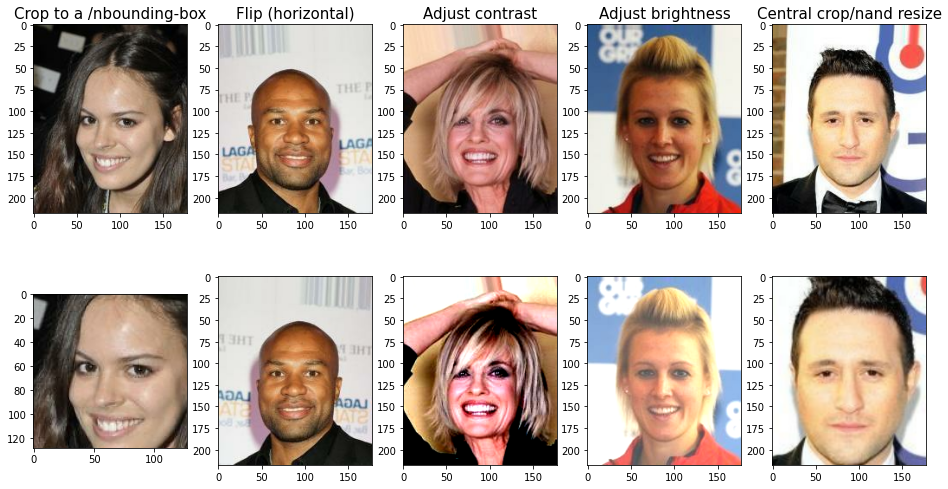

In [7]:
import matplotlib.pyplot as plt
examples = []
for example in celeba_train.take(5):
  examples.append(example['image'])

fig = plt.figure(figsize=(16, 8.5))
ax = fig.add_subplot(2,5,1)
ax.set_title('Crop to a /nbounding-box', size=15)
ax.imshow(examples[0])
ax = fig.add_subplot(2,5,6)
img_cropped = tf.image.crop_to_bounding_box(examples[0], 50, 20, 128, 128)
ax.imshow(img_cropped)
ax =fig.add_subplot(2,5,2)
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(examples[1])
ax = fig.add_subplot(2,5,7)
img_flipped = tf.image.flip_left_right(examples[1])
ax.imshow(img_flipped)
ax = fig.add_subplot(2,5,3)
ax.set_title('Adjust contrast', size=15)
ax.imshow(examples[2])
ax=fig.add_subplot(2,5,8)
img_adj_contrast = tf.image.adjust_contrast(examples[2], contrast_factor=2)
ax.imshow(img_adj_contrast)
ax=fig.add_subplot(2,5,4)
ax.set_title('Adjust brightness', size=15)
ax.imshow(examples[3])
ax =fig.add_subplot(2,5,9)
img_adj_brightness = tf.image.adjust_brightness(examples[3], delta=0.3)
ax.imshow(img_adj_brightness)
ax = fig.add_subplot(2,5,5)
ax.set_title('Central crop/nand resize', size=15)
ax.imshow(examples[4])
ax = fig.add_subplot(2,5,10)
img_center_crop = tf.image.central_crop(examples[4], 0.7)
img_resized = tf.image.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized.numpy().astype('uint8'))
plt.show()

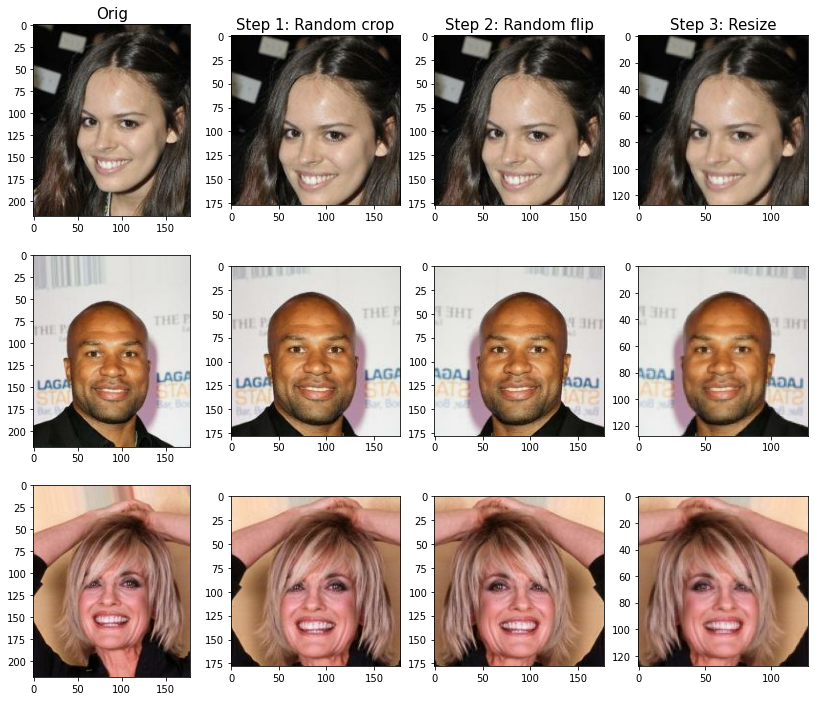

In [9]:
tf.random.set_seed(1)
fig = plt.figure(figsize=(14,12))
for i, example in enumerate(celeba_train.take(3)):
  image = example['image']
  ax =fig.add_subplot(3,4, i * 4+1)
  ax.imshow(image)
  if i == 0:
    ax.set_title('Orig', size=15)

  ax = fig.add_subplot(3,4,i*4+2)
  img_crop = tf.image.random_crop(image, size=(178,178,3))
  ax.imshow(img_crop)
  if i == 0:
    ax.set_title('Step 1: Random crop', size=15)
  
  ax = fig.add_subplot(3,4, i*4 + 3)
  img_flip = tf.image.random_flip_left_right(img_crop)
  ax.imshow(img_flip)
  if i == 0:
    ax.set_title('Step 2: Random flip', size=15)
  
  ax = fig.add_subplot(3,4, i * 4+4)
  img_resize=tf.image.resize(img_flip, size=(128, 128))
  ax.imshow(tf.cast(img_resize, tf.uint8))
  if i == 0:
    ax.set_title('Step 3: Resize', size=15)

plt.show()

In [10]:
def preprocess(example, size=(64,64), mode='train'):
  image = example['image']
  label = example['attributes']['Male']
  if mode == 'train':
    image_cropped = tf.image.random_crop(image, size=(178,178, 3))
    image_resized = tf.image.resize(image_cropped, size=size)
    image_flip = tf.image.random_flip_left_right(image_resized)
    return (image_flip/ 255.0, tf.cast(label, tf.int32))
  else: 
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=178, target_width=178)
    image_resized = tf.image.resize(image_cropped, size=size)
    return (image_resized/255.0, tf.cast(label, tf.int32))